### ДЗ к уроку 5 "Кейс 1. Аномалии и артефакты"

In [1]:
brent_url='my_BRENT2019.csv'
rub_dol_url='RС_Доллар_01_09_2010_T01_09_2019.xlsx'
rub_euro_url='RC_Евро_01_09_2010_T01_09_2019.xlsx'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-whitegrid')

#### 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [4]:
df_brent = pd.read_csv(brent_url, index_col='Дата', parse_dates=['Дата'])
df_brent.index.names = ['data']
df_brent.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
data,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [5]:
df_brent['diff_oil'] = df_brent['Значение'].diff(periods=1).fillna(0)

In [6]:
df_brent.iloc[[0,-1]]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff_oil
data,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.00
2019-09-01,58.84,2019,9,1,3,244,35,6,0,1,0,-0.35


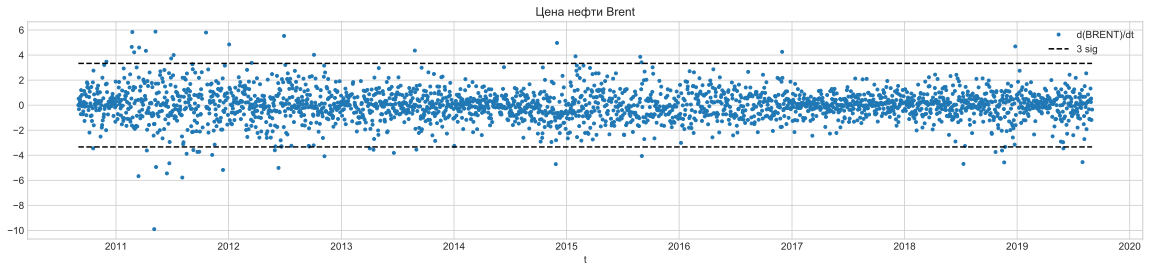

In [7]:
s_brent = np.std(df_brent.diff_oil)**0.5 *3
plt.figure(figsize=(20,4))
plt.plot(df_brent.index, df_brent.diff_oil, '.', label='d(BRENT)/dt')
plt.plot(df_brent.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(df_brent.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent')
plt.show()

#### 2.1 Добавьте первые разности по стоимости доллара и евро к рублю

In [8]:
df_rub_dol = pd.read_excel(rub_dol_url, index_col='data', parse_dates=['data'])
df_rub_dol.head()

,nominal,curs,cdx
data,,,
2010-09-01,1,30.8669,Доллар США
2010-09-02,1,30.8001,Доллар США
2010-09-03,1,30.6858,Доллар США
2010-09-04,1,30.6922,Доллар США
2010-09-07,1,30.5771,Доллар США


In [9]:
df_rub_euro =  pd.read_excel(rub_euro_url, index_col='data', parse_dates=['data'])
df_rub_euro.head()

,nominal,curs,cdx
data,,,
2010-09-01,1,39.0127,Евро
2010-09-02,1,39.1654,Евро
2010-09-03,1,39.2901,Евро
2010-09-04,1,39.3505,Евро
2010-09-07,1,39.4720,Евро


In [10]:
df_brent['diff_usd'] = df_rub_dol.curs.diff(periods=1).fillna(0)
df_brent['diff_eur'] = df_rub_euro.curs.diff(periods=1).fillna(0)

In [11]:
df_brent.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff_oil,diff_usd,diff_eur
data,,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.00,0.0000,0.0000
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0.52,-0.0668,0.1527
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,-0.32,-0.1143,0.1247
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.05,0.0064,0.0604
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0.01,NaN,NaN


#### 2.2 делайте ее перерасчет (ресемплинг) в представление по неделям.

In [12]:
df_w = df_brent[['diff_oil', 'diff_usd', 'diff_eur', 'Значение']] \
            .resample('W') \
            .mean()
df_w.fillna(method='ffill', inplace=True)

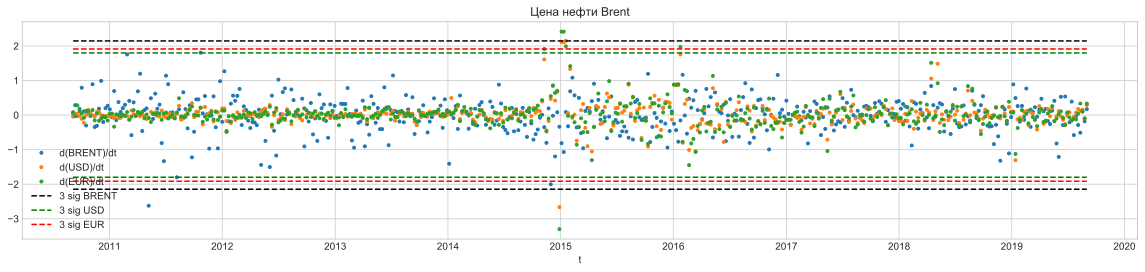

In [13]:
s_brent = np.std(df_w.diff_oil)**0.5 *3
s_dollar = np.std(df_w.diff_usd)**0.5 *3
s_euro = np.std(df_w.diff_eur)**0.5 *3


plt.figure(figsize=(20,4))
plt.plot(df_w.index, df_w.diff_oil, '.', label='d(BRENT)/dt')

plt.plot(df_w.index, df_w.diff_usd, '.', label='d(USD)/dt')
plt.plot(df_w.index, df_w.diff_eur, '.', label='d(EUR)/dt')

plt.plot(df_w.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig BRENT')
plt.plot(df_w.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')

plt.plot(df_w.iloc[[0,-1]].index,[s_dollar, s_dollar],'--k', color='green', label ='3 sig USD')
plt.plot(df_w.iloc[[0,-1]].index,[-s_dollar, -s_dollar],'--k', color='green')

plt.plot(df_w.iloc[[0,-1]].index,[s_euro, s_euro],'--k', color='red', label ='3 sig EUR')
plt.plot(df_w.iloc[[0,-1]].index,[-s_euro, -s_euro],'--k', color='red')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent')
plt.show()

#### 3. Постройте модель предсказания 1-й точки от текущей (h=1).

In [14]:
def split_data(data, split_date):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

In [15]:
scl_target=StandardScaler() 

h=1

target = df_w["Значение"].values[h:].reshape((df_w.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(469, 1)

In [16]:
scl_x=StandardScaler() 

X = df_w.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(469, 4)

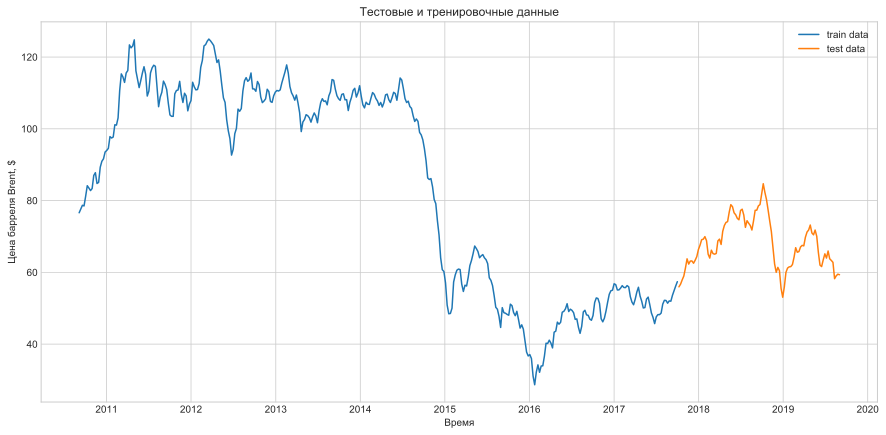

In [17]:
train, test = split_data(df_w[-2000:], -100)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Цена барреля Brent, $')
plt.plot(train.index,train['Значение'], label='train data' )
plt.plot(test.index,test['Значение'], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

In [18]:
X_train = X[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

In [19]:
model_g = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_l = LinearRegression()

In [20]:
model_l.fit(X_train, y_train) 
model_g.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [21]:
y_train_pred_g = model_g.predict(X_train)
y_train_pred_l= model_l.predict(X_train)
y_test_pred_g = model_g.predict(X_test)
y_test_pred_l= model_l.predict(X_test)

In [22]:
y_train.shape

(370,)

In [23]:
test[h:].shape

(99, 4)

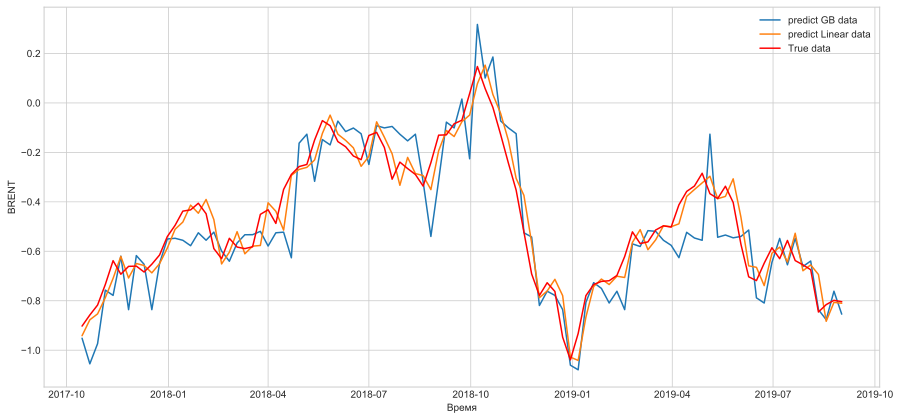

In [24]:
plt.figure(figsize=(15,7))

plt.xlabel('Время')
plt.ylabel('BRENT')

plt.plot(test.index[h:], y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h:], y_test_pred_l, label='predict Linear data' )

plt.plot(test.index[h:], y_test, color='red', label='True data')

plt.legend()
plt.show()

#### 4. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   3.895397272385685 %


In [27]:
er_l = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_l))

print('ошибка линейной регрессии MAPE :  ', er_l,'%')

ошибка линейной регрессии MAPE :   2.036337167799078 %


Вывод: Ошибка значительно уменьшилась. Есть линейная связь между разностями цены на нефть и кросс-курсов.